# 🎲 Board Games Analysis Project 🎲
----

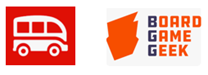

#### 🚀 Authors : Maxence Dauphin, Bernhard Riemer, Mónica Costa, Tahar Guenfoud, Konstantin Shapovalov
#### 🎯 Batch #1835 Data Science Flex



# Importing Libraries
------

In [1]:
import os
import subprocess
import re

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display="diagram")
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

ModuleNotFoundError: No module named 'xgboost'

# Load data from Kaggle
---

In [7]:
# Define the path to raw_data repo
raw_data_path = "~/code/riemerb/maxencedauphin/raw_data"
raw_data_path = os.path.expanduser(raw_data_path)

# Define the url to Kaggle data
kaggle_data_path = "https://www.kaggle.com/api/v1/datasets/download/melissamonfared/board-games"

# Define the archive path
archive_path = os.path.join(raw_data_path, "archive.zip")

# Check if the archive exists
if os.path.exists(archive_path):
    try:
        print("Archive exists. Please enter 'yes' to reload data or 'no' to keep existing data.")
        user_input = input("Enter your choice (yes/no): ")

        if user_input.lower() == "yes":
            subprocess.run(f"curl -L -o {archive_path} {kaggle_data_path}", shell=True)
            subprocess.run(f"unzip -o {archive_path} -d {raw_data_path}", shell=True)
        else:
            print("Keeping existing data.")
    except EOFError:
        print("User input not supported in this environment. Proceeding with default action.")
        print("Keeping existing data.")
else:
    subprocess.run(f"curl -L -o {archive_path} {kaggle_data_path}", shell=True)
    subprocess.run(f"unzip {archive_path} -d {raw_data_path}", shell=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  754k    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (56) Failure writing output to destination, passed 1357 returned 4294967295
unzip:  cannot find or open /Users/bernhardriemer/code/riemerb/maxencedauphin/raw_data/archive.zip, /Users/bernhardriemer/code/riemerb/maxencedauphin/raw_data/archive.zip.zip or /Users/bernhardriemer/code/riemerb/maxencedauphin/raw_data/archive.zip.ZIP.


In [8]:
filepath = "~/code/riemerb/maxencedauphin/bgg-project/raw_data/BGG_Data_Set.csv"
df_orig = pd.read_csv(filepath, encoding='ISO-8859-1')
df = df_orig.copy()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bernhardriemer/code/riemerb/maxencedauphin/bgg-project/raw_data/BGG_Data_Set.csv'

# EDA
---

In [ ]:
df.head(2)

In [ ]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

In [ ]:
# DUPLICATES
df.duplicated().sum()

In [ ]:
df.info()

In [ ]:
df.dtypes.value_counts()

In [ ]:
df.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)

In [ ]:
df.select_dtypes(include=["float64"]).nunique().sort_values(ascending=False)

In [ ]:
df.select_dtypes(include=["int64"]).nunique().sort_values(ascending=False)

In [ ]:
df.describe()

#### 🤔 My reflections:

- convert column names to lowercase and replace spaces with underscores to facilitate using pandas df.name syntax
- remove the game ID column as it does not provide inherent information about the game's quality or rating
- remove rows where the value for owned_users is NaN
- replace missing values in the mechanics and domains columns with "unspecified"
- rework mechanics and domains columns which contains a list of strings
- we have numerous categorical values to encode: 19,974 for name, 7,379 for mechanics, and 40 for domains. To maintain a simple basic model, I removed the name column

TODO
- we need to rework the year_published column to handle NaN, 0, and negative values, which represent very old games dated "BC"
- we need to transform the list values in mechanics and domains into something more meaningful
- ...


#### 🛍️ Convert column names to lowercase and replace spaces with underscores to facilitate using pandas df.name syntax

In [ ]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Output the transformed column names
print(df.columns)

#### 🛍️ Remove the game ID column as it does not provide inherent information about the game's quality or rating

In [ ]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

In [ ]:
df.drop(columns=['id'], inplace=True)

In [ ]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

#### 🛍️ Remove rows where the value for owned_users is NaN

In [ ]:
df = df[df['owned_users'].notna()]

In [ ]:
rows, col = df.shape
print(f"Total rows : {rows}, Total columns : {col}")

#### 🛍️ Replace missing values in the mechanics and domains columns with "unspecified"

In [ ]:
print("Columns with missing values:", df.columns[df.isnull().any()])

In [ ]:
df["mechanics"] = df["mechanics"].fillna("unspecified")
df["domains"] = df["domains"].fillna("unspecified")

In [ ]:
print("Columns with missing values:", df.columns[df.isnull().any()])

#### 🛍️ Rework mechanics and domains columns which contains a list of strings

In [ ]:
def clean(text):
    cln = re.sub('[^a-zA-Z], ,', ' ', str(text))
    cln = cln.replace("/",",")
    cln = cln.split()
    cln = ' '.join(cln)
    return cln
df["mechanics"] = df["mechanics"].apply(clean)
df["domains"] = df["domains"].apply(clean)

#### 🛍️ Transform 'year_published' column to datetime type -> TODO

In [ ]:
#df['year_published'].dtype

In [ ]:
n" df['year_published'].unique()

In [ ]:
# TODO
# negative_zero_nan_rows = df[(df['year_published'] <= 0) | df['year_published'].isna()]

# BASELINE
---

In [ ]:
df_clean = df.copy()

In [ ]:
# we have numerous categorical values to encode: 19,974 for name, 7,379 for mechanics, and 40 for domains. To maintain a simple basic model, I removed the name column
df_clean.drop(columns=['name'], inplace=True)
df_clean.columns

In [ ]:
# Split data into features (X) and target (y)
# We want to predict Average Ratings
X = df_clean.drop('rating_average', axis=1)
y = df_clean['rating_average']

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

#### categorical features

In [ ]:
df_clean.select_dtypes(include=["object"]).nunique().sort_values(ascending=False)

In [ ]:
categorical_features_unique = df_clean.select_dtypes(include=["object"]).nunique()
categorical_features_unique.sum()

In [ ]:
preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False)
)

preproc_categorical_baseline

#### numerical features

In [ ]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_numerical_baseline

In [ ]:
preproc_baseline = ColumnTransformer([
    ("num_transform", preproc_numerical_baseline, make_column_selector(dtype_include=np.number)),
    ("cat_transform", preproc_categorical_baseline, make_column_selector(dtype_exclude=np.number))
]).set_output(transform="pandas")

In [ ]:
pipeline_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipeline_baseline

In [ ]:
cv_score = cross_val_score(pipeline_baseline, X_train, y_train, cv=5).mean()
print(f"Cross-validation score: {cv_score}")

In [ ]:
#pipeline_baseline.get_params()

In [ ]:
pipeline_baseline.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = pipeline_baseline.predict(X_test)

In [ ]:
Evaluate the model on the test set
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

In [ ]:
import pickle
models_path = os.path.expanduser("~/code/maxencedauphin/bgg-project/models")
pickle_file_path = os.path.join(models_path, "pipeline_baseline.pkl")
# Export Pipeline as pickle file
with open(pickle_file_path, "wb") as file:
    pickle.dump(pipeline_baseline, file)

print(f"Model saved to: {pickle_file_path}")